In [1]:
OPENSLIDE_PATH = r"C:\Users\sakthi01\Downloads\openslide-bin-4.0.0.3-windows-x64\openslide-bin-4.0.0.3-windows-x64\bin"
import os
if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [10]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
import networkx as nx
import skimage.morphology as morphology
from skimage.filters import sobel
from skimage.color import rgb2gray
import xmltodict

In [5]:
# Load the WSI file
slide_path = r"C:\Users\sakthi01\Downloads\BEST2_CAM_0012_HE_1.svs"
slide = openslide.OpenSlide(slide_path)

In [95]:
# Read Geojson file
atypia_xml = r"C:\Users\sakthi01\Downloads\BEST2_CAM_0012_HE_1_nuclei_atypia.xml"
with open(atypia_xml) as f:
    atypia = xmltodict.parse(f.read())
atypia = atypia['ASAP_Annotations']['Annotations']['Annotation']
atypia_nuclei, atypia_gland = [], []

for i in atypia:
    if i['@PartOfGroup'] == 'tissue':
        atypia_nuclei.append([[int(float(j['@X'])), int(float(j['@Y']))] for j in i['Coordinates']['Coordinate']])
    elif i['@PartOfGroup'] == 'Gastric-type columnar epithelium':
        atypia_gland.append([[int(float(j['@X'])), int(float(j['@Y']))] for j in i['Coordinates']['Coordinate']])

print(len(atypia_nuclei), len(atypia_gland))
print(atypia_nuclei[0])


15 1
[[37450, 18221], [37447, 18222], [37443, 18227], [37443, 18230], [37444, 18236], [37448, 18242], [37450, 18245], [37454, 18245], [37456, 18247], [37458, 18249], [37460, 18250], [37463, 18251], [37466, 18250], [37468, 18243], [37465, 18236], [37463, 18231], [37462, 18228], [37456, 18225]]


In [96]:
normal_xml = r"C:\Users\sakthi01\Downloads\BEST2_CAM_0012_HE_1_nuclei_normal.xml"
with open(normal_xml) as f:
    normal = xmltodict.parse(f.read())
normal = normal['ASAP_Annotations']['Annotations']['Annotation']
normal_nuclei, normal_gland = [], []

for i in normal:
    if i['@PartOfGroup'] == 'tissue':
        normal_nuclei.append([[int(float(j['@X'])), int(float(j['@Y']))] for j in i['Coordinates']['Coordinate']])
    elif i['@PartOfGroup'] == 'Gastric-type columnar epithelium':
        normal_gland.append([[int(float(j['@X'])), int(float(j['@Y']))] for j in i['Coordinates']['Coordinate']])
                            
print(len(normal_nuclei), len(normal_gland))
print(normal_nuclei[0])

31 1
[[40992, 22960], [40987, 22962], [40982, 22965], [40979, 22969], [40978, 22975], [40978, 22981], [40981, 22986], [40986, 22989], [40992, 22988], [40997, 22985], [41001, 22981], [41004, 22975], [41005, 22969], [41004, 22967], [41001, 22962], [40998, 22960]]


In [104]:
# Function to extract the region based on boundary coordinates
def extract_region(slide, coordinates):
    coordinates = np.array(coordinates)
    min_x, min_y = coordinates.min(axis=0)
    max_x, max_y = coordinates.max(axis=0)
    width, height = max_x - min_x, max_y - min_y
    image = slide.read_region((min_x, min_y), 0, (width, height))
    return np.array(image)[:, :, :3]  # Drop the alpha channel

In [118]:
np.mean(rgb2gray(extract_region(slide, atypia_nuclei[12])))

0.7096300818850267

In [153]:
# Calculate features for a single nucleus
def calculate_nucleus_features(image):
    gray_image = rgb2gray(image)
    properties = regionprops(label(gray_image < np.percentile(gray_image, 50)))[0] # Binary Mask of Nucleus

    features = {
        'area': properties.area, # Nuclear enlargement, pleomorphism
        'centroid': properties.centroid, # Distance measures
        'eccentricity': properties.eccentricity, # Elongation
        'perimeter': properties.perimeter,       # Boundaries
        'major_axis': properties.axis_major_length,
        'minor_axis': properties.axis_minor_length,
        'intensity':  np.mean(gray_image), # Mean intensity of pixels within nucleus region (bounded between 0 and 1)
        'elliptical_area': (np.pi * properties.axis_major_length * properties.axis_minor_length) / 4
    }
    return features

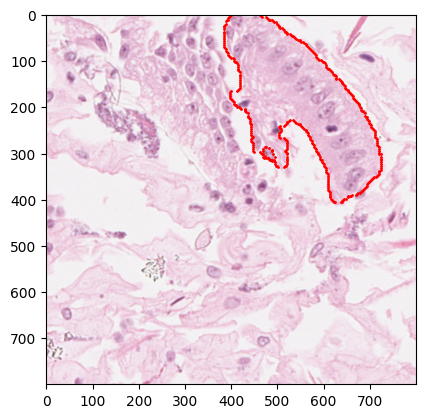

In [74]:
plt.imshow(atypia_gland_region)
for i in atypia_gland[0]:
    plt.scatter(i[0] - x_shift, i[1] - y_shift, c = 'r', s = 1)
for j in atypia_nuclei[0]:
    plt.scatter(j[0] - x_shift, j[1] - y_shift, c = 'r', s = 1)
plt.show()

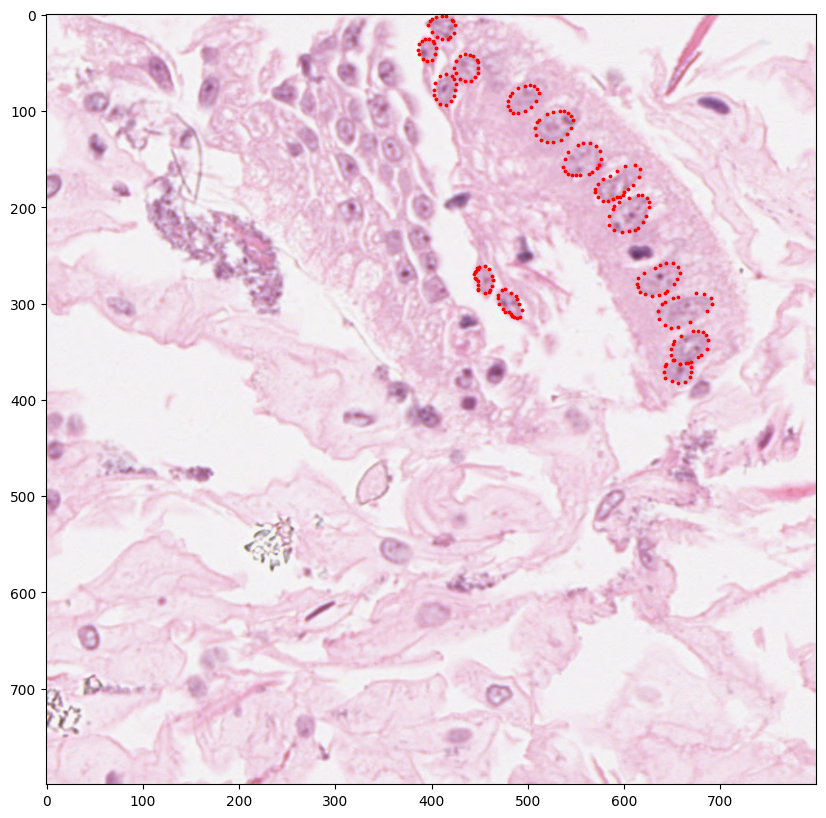

In [50]:
# Plot atypia gland with nuclei
plt.figure(figsize=(10, 10))
x_shift = atypia_gland[0][0][0]-400
y_shift = atypia_gland[0][0][1]
# Region of Atypia Gland
atypia_gland = np.array(atypia_gland)
atypia_gland_region = slide.read_region((x_shift, y_shift), 0, (800,800))
plt.imshow(atypia_gland_region)
for i in atypia_nuclei:
    for j in i:
        plt.scatter(j[0] - x_shift, j[1] - y_shift, c='r', s=3)
plt.show()

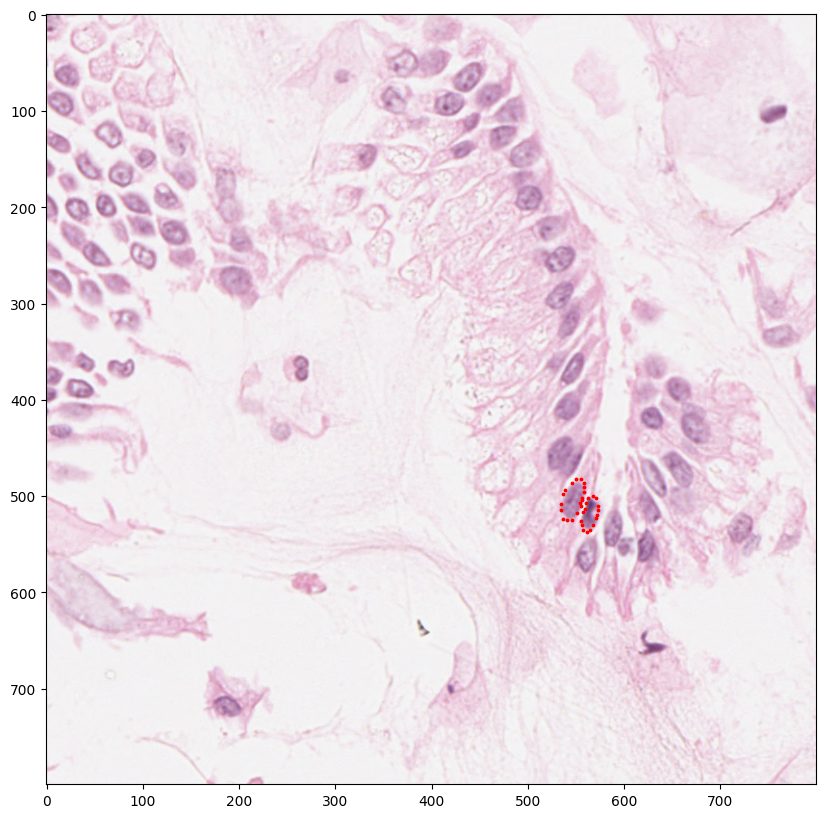

In [165]:
# Plot normal gland with nuclei
level = 0
x_shift = normal_gland[0][0][0]-400
y_shift = normal_gland[0][0][1]

# Region of Normal Gland
normal_gland = np.array(normal_gland)
normal_gland_region = slide.read_region((x_shift, y_shift), level, (800,800))
plt.figure(figsize=(10, 10))
plt.imshow(normal_gland_region)
for i in normal_nuclei[21:23]:
    for j in i:
        plt.scatter(j[0]-x_shift, j[1]-y_shift, c='r', s=3)
plt.show()

In [131]:
# Loss of Nuclear Polarity Metric (Distance from the gland boundary)
def min_boundary_distance(nucleus, gland):
    # Convert to np arrays
    nucleus = np.array(nucleus)
    gland = np.array(gland)
    
    current_minimum = np.inf
    for i in range(len(nucleus)):
        for j in range(len(gland)):
            distance = np.linalg.norm(nucleus[i] - gland[j])
            if distance < current_minimum:
                current_minimum = distance
    return current_minimum

def global_avg(nuclei, gland):
    avg_distance = 0
    for i in range(len(nuclei)):
        dist = min_boundary_distance(nuclei[i], gland)
        avg_distance += dist
    return avg_distance/len(nuclei)

In [128]:
avg_distance = 0
for i in range(len(atypia_nuclei)):
    dist = min_boundary_distance(atypia_nuclei[i], atypia_gland[0])
    print(f'Nuclei {i}: {dist}')
    avg_distance += dist
print(f'Average deviation from the gland boundary: {avg_distance / len(atypia_nuclei)}')

Nuclei 0: 0.0
Nuclei 1: 0.0
Nuclei 2: 7.0710678118654755
Nuclei 3: 18.439088914585774
Nuclei 4: 28.160255680657446
Nuclei 5: 30.01666203960727
Nuclei 6: 38.18376618407357
Nuclei 7: 23.706539182259394
Nuclei 8: 41.617304093369626
Nuclei 9: 40.311288741492746
Nuclei 10: 35.77708763999664
Nuclei 11: 36.76955262170047
Nuclei 12: 3.605551275463989
Nuclei 13: 1.4142135623730951
Nuclei 14: 3.1622776601683795
Average deviation from the gland boundary: 20.54897702717426


In [87]:
avg_distance = 0
for i in range(len(normal_nuclei)):
    dist = min_boundary_distance(np.array(normal_nuclei[i]), np.array(normal_gland[0]))
    print(f'Nuclei {i}: {dist}')
    avg_distance += dist
print(f'Average deviation from the gland boundary: {avg_distance / len(normal_nuclei)}')

Nuclei 0: 15.231546211727817
Nuclei 1: 6.0
Nuclei 2: 0.0
Nuclei 3: 4.123105625617661
Nuclei 4: 50.695167422546305
Nuclei 5: 8.06225774829855
Nuclei 6: 17.69180601295413
Nuclei 7: 0.0
Nuclei 8: 13.341664064126334
Nuclei 9: 46.69047011971501
Nuclei 10: 58.59180830116101
Nuclei 11: 0.0
Nuclei 12: 11.661903789690601
Nuclei 13: 14.866068747318506
Nuclei 14: 21.0
Nuclei 15: 29.120439557122072
Nuclei 16: 30.01666203960727
Nuclei 17: 34.132096331752024
Nuclei 18: 25.942243542145693
Nuclei 19: 55.0
Nuclei 20: 25.079872407968907
Nuclei 21: 39.6232255123179
Nuclei 22: 43.266615305567875
Nuclei 23: 27.51363298439521
Nuclei 24: 46.010868281309364
Nuclei 25: 20.615528128088304
Nuclei 26: 34.66987164671943
Nuclei 27: 12.649110640673518
Nuclei 28: 7.0
Nuclei 29: 0.0
Nuclei 30: 4.123105625617661
Average deviation from the gland boundary: 22.6683570982723


In [154]:
def gland_graph(nuclei, gland):
    # Create Graph Level Attributes
    avg_min_bounding_distance = global_avg(nuclei, gland)
    print(avg_min_bounding_distance)

    # Create the graph
    G = nx.Graph(polarity_measure = avg_min_bounding_distance)

    # Extracting gland and nuclei images and adding nodes
    gland_image = extract_region(slide, gland)
    nuclei_images = [extract_region(slide, nuc) for nuc in nuclei]

    for idx, nucleus_img in enumerate(nuclei_images):
        features = calculate_nucleus_features(nucleus_img)
        G.add_node(idx, **features)

    # Adding edges
    for i in range(len(nuclei_images)):
        for j in range(i + 1, len(nuclei_images)):
            paired_distance = np.linalg.norm(np.array(G.nodes[i]['centroid']) - np.array(G.nodes[j]['centroid']))
            size_difference = np.abs(G.nodes[i]['area'] - G.nodes[j]['area'])
            G.add_edge(i, j, distance = paired_distance, size_difference = size_difference)
            

    # Visualization of the graph
    pos = {i: (props['centroid'][1], props['centroid'][0]) for i, props in G.nodes(data=True)}
    nx.draw(G, pos, with_labels=True, node_color='lightblue')
    plt.show()

    # Return Graph Object
    return G

20.54897702717426


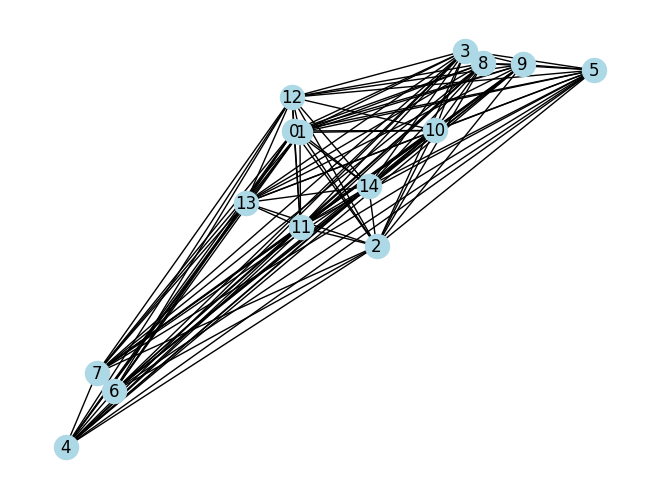

In [155]:
atypia_graph = gland_graph(atypia_nuclei, atypia_gland[0])

22.6683570982723


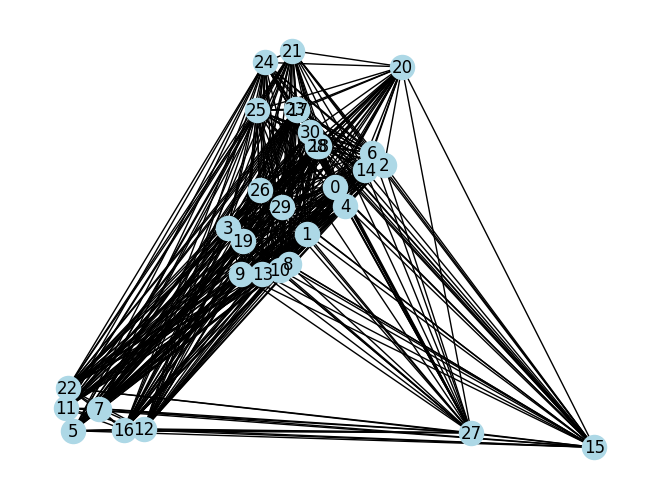

In [156]:
normal_graph = gland_graph(normal_nuclei, normal_gland[0])
normal_graph

In [158]:
atypia_graph.nodes[0]

{'area': 375.0,
 'centroid': (15.192, 12.146666666666667),
 'eccentricity': 0.8493463191882294,
 'perimeter': 130.12489168102783,
 'major_axis': 33.7165252074473,
 'minor_axis': 17.79679539011991,
 'intensity': 0.7248059607843138,
 'elliptical_area': 471.27510519442046}

In [136]:
atypia_graph.edges[(0, 1)]

{'distance': 0.25289296708171, 'size_difference': 98.0}

In [137]:
atypia_graph.graph

{'polarity_measure': 20.54897702717426}

In [173]:
normal_graph.nodes[22]

{'area': 19.0,
 'centroid': (3.5789473684210527, 0.5789473684210527),
 'eccentricity': 0.9791990032154844,
 'perimeter': 15.207106781186548,
 'major_axis': 12.306900311456488,
 'minor_axis': 2.4970974315388457,
 'intensity': 0.6356017635282342,
 'elliptical_area': 24.13648655904326}